In [33]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math

In [34]:
movies = pd.read_csv('https://raw.githubusercontent.com/AdilsonAngelo/ProjetoDataScience/master/movies.csv', index_col='imdbID')
movies = movies[(movies.Year >= 2009) & (movies.Year <= 2019) & (movies.Type == 'movie')]

# Pre-Processamento

In [35]:
# Dropando colunas irrelevantes
movies = movies[movies.Type == 'movie']
movies = movies.drop(columns=['Plot', 'Poster', 'Website', 'Type'])
movies.head()

# Removendo duplicatas
movies.drop_duplicates(keep = 'first', inplace = True)

In [36]:
def find_awards(s, regex):
  s = str(s)
  awards = 0
  temp = re.findall(regex, str(s))
  if temp:
    for t in temp:
      awards += int(t)
  return awards

# 'Golden Globe'
# 'Oscar'
# 'Primetime Emmys'
# 'BAFTA Film Award'

movies['oscars'] = movies.Awards.apply(lambda x: find_awards(x, r'Won (\d+) Oscar'))
movies['baftas'] = movies.Awards.apply(lambda x: find_awards(x, r'Won (\d+) BAFTA'))
movies['primetime_emmys'] = movies.Awards.apply(lambda x: find_awards(x, r'Won (\d+) Primetime'))
movies['golden_globes'] = movies.Awards.apply(lambda x: find_awards(x, r'Won (\d+) Golden Globe'))

movies['oscars_nom'] = movies.Awards.apply(lambda x: find_awards(x, r'Nominated for (\d+) Oscar'))
movies['baftas_nom'] = movies.Awards.apply(lambda x: find_awards(x, r'Nominated for (\d+) BAFTA'))
movies['primetime_emmys_nom'] = movies.Awards.apply(lambda x: find_awards(x, r'Nominated for (\d+) Primetime'))
movies['golden_globes_nom'] = movies.Awards.apply(lambda x: find_awards(x, r'Nominated for (\d+) Golden Globe'))

movies['other_awards'] = movies.Awards.apply(lambda x: find_awards(x, r'(\d+) win'))
movies['other_nominations'] = movies.Awards.apply(lambda x: find_awards(x, r'(\d+) nomination'))

movies = movies.drop(columns=['Awards'])

In [37]:
# Setando campos categóricos

movies.Title = movies.Title.astype('category')

movies.Rated = movies.Rated.astype('category')

movies.Genre = movies.Genre.str.replace(r',(.*)', '')
movies.Genre = movies.Genre.astype('category')

movies.Director = movies.Director.str.replace(r',(.*)', '')
movies.Director = movies.Director.astype('category')

movies.Writer = movies.Writer.str.replace(r'\((.*)\)', '').str.replace(r',(.*)', '').str.strip()
movies.Writer = movies.Writer.astype('category')

movies.Actors = movies.Actors.str.replace(r',(.*)', '')
movies['leading_actor'] = movies.Actors.astype('category')
movies = movies.drop(columns=['Actors'])

movies.Language = movies.Language.str.replace(r',(.*)', '')
movies.Language = movies.Language.astype('category')

movies.Country = movies.Country.str.replace(r',(.*)', '')
movies.Country = movies.Country.astype('category')

movies.Production = movies.Production.str.replace(r',(.*)', '')
movies.Production = movies.Production.astype('category')

In [38]:
# Configurando campos numéricos que estão como strings
# Limpando BoxOffice
movies['BoxOffice'] = movies[~movies['BoxOffice'].isnull()].BoxOffice.str.replace('$', '').str.replace(',', '').str.replace('k', '000')
mask = (movies.BoxOffice.str.startswith('&pound;')) & (~movies.BoxOffice.isnull())
movies.loc[mask, 'BoxOffice'] = movies.loc[mask, 'BoxOffice'].apply(lambda x: 1.4 * float(str(x).replace('&pound;', '')))
movies['BoxOffice'] = movies[~movies.BoxOffice.isnull()]['BoxOffice'].astype(float)

# Limpando imdbVotes
movies['imdbVotes'] = movies.imdbVotes.str.replace(',', '').astype(float)

# Released e DVD para datetime
movies.Released = pd.to_datetime(movies.Released, errors='coerce')
movies.DVD = pd.to_datetime(movies.DVD, errors='coerce')

In [39]:
print(movies.dtypes, (movies.isnull()).sum(), '\ndataset size: '+str(len(movies)))

# 104662 eh todo o universo de filmes catalogados de 2009 - 2019
# Devido a grande quantidade de dados ausentes eh necessario estabelecer uma amostra

Title                        category
Year                            int64
Rated                        category
Released               datetime64[ns]
Runtime                       float64
Genre                        category
Director                     category
Writer                       category
Language                     category
Country                      category
Metascore                     float64
imdbRating                    float64
imdbVotes                     float64
DVD                    datetime64[ns]
BoxOffice                     float64
Production                   category
tomatoes                      float64
oscars                          int64
baftas                          int64
primetime_emmys                 int64
golden_globes                   int64
oscars_nom                      int64
baftas_nom                      int64
primetime_emmys_nom             int64
golden_globes_nom               int64
other_awards                    int64
other_nomina

## Dados ausentes

In [40]:
# TRATAMENTO DE DADOS AUSENTES
movies1 = movies
# Categoricos
movies1 = movies1[pd.notnull(movies1['Genre'])]
movies1 = movies1[pd.notnull(movies1['Director'])]
movies1 = movies1[pd.notnull(movies1['Language'])]
movies1 = movies1[pd.notnull(movies1['Country'])]
movies1 = movies1[pd.notnull(movies1['leading_actor'])]
# Numericos
movies1 = movies1[pd.notnull(movies1['Released'])]
movies1 = movies1[pd.notnull(movies1['imdbRating'])]
movies1 = movies1[pd.notnull(movies1['tomatoes'])]

print(movies1.isnull().sum(), '\n', len(movies1))

Title                     0
Year                      0
Rated                  1830
Released                  0
Runtime                  14
Genre                     0
Director                  0
Writer                  667
Language                  0
Country                   0
Metascore              2181
imdbRating                0
imdbVotes                 0
DVD                    2606
BoxOffice              4570
Production              832
tomatoes                  0
oscars                    0
baftas                    0
primetime_emmys           0
golden_globes             0
oscars_nom                0
baftas_nom                0
primetime_emmys_nom       0
golden_globes_nom         0
other_awards              0
other_nominations         0
leading_actor             0
dtype: int64 
 6917


In [41]:
# Ainda assim sobram colunas com mais de 70% de dados ausentes, então decido remove-las
movies1 = movies1.dropna(thresh=.7*len(movies1), axis=1)

print(movies1.isnull().sum(), '\n', len(movies1))

Title                     0
Year                      0
Rated                  1830
Released                  0
Runtime                  14
Genre                     0
Director                  0
Writer                  667
Language                  0
Country                   0
imdbRating                0
imdbVotes                 0
Production              832
tomatoes                  0
oscars                    0
baftas                    0
primetime_emmys           0
golden_globes             0
oscars_nom                0
baftas_nom                0
primetime_emmys_nom       0
golden_globes_nom         0
other_awards              0
other_nominations         0
leading_actor             0
dtype: int64 
 6917


In [42]:
# Sobram 14 filmes com Runtime ausentes, portanto, para essa quantidade sera feita imputacao com a mediana (k-nn seria muito custoso para 14 dados faltantes)
# Ainda sobram filmes suficientes para uma amostra relevante

movies1.Runtime.fillna(movies1.Runtime.median(), inplace=True)

print(movies1.isnull().sum(), '\n', len(movies1))

Title                     0
Year                      0
Rated                  1830
Released                  0
Runtime                   0
Genre                     0
Director                  0
Writer                  667
Language                  0
Country                   0
imdbRating                0
imdbVotes                 0
Production              832
tomatoes                  0
oscars                    0
baftas                    0
primetime_emmys           0
golden_globes             0
oscars_nom                0
baftas_nom                0
primetime_emmys_nom       0
golden_globes_nom         0
other_awards              0
other_nominations         0
leading_actor             0
dtype: int64 
 6917


## Remoção de outliers

In [43]:
# Remocao de outliers


# Removendo outliers usando tukey
# deixa um numero de linhas inferior ao z-score robusto

q1 = movies1['Runtime'].quantile(q=0.25)
q3 = movies1['Runtime'].quantile(q=0.75)
iqr = q3 - q1

movies_tukey = movies1[(movies1['Runtime'] > (q1-1.5*iqr)) & (movies1['Runtime'] < (q3+1.5*iqr))]
len(movies_tukey)

6583

(0.8708786964416504, 0.0)
(6712, 25)
(0.9706310033798218, 6.039849538699488e-35)


c:\users\aange\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\users\aange\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


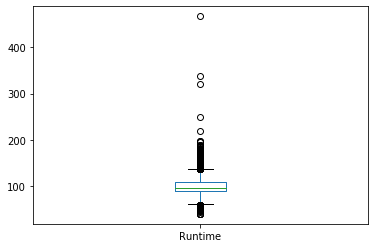

In [44]:
# Removendo com z-score robusto

# pelo teste de shapiro a coluna Runtime é 87% uma gaussiana
# após a remoção de outliers esse numero sobe para 97%
print(stats.shapiro(movies1.Runtime))

movies1.Runtime.plot.box()
mad = np.abs(movies1['Runtime'] - movies1['Runtime'].median()).median()*(1/0.6745)
movies1 = movies1[(np.abs(movies1['Runtime']-movies1['Runtime'].median())/mad < 3.5)]
print(movies1.shape)
print(stats.shapiro(movies1.Runtime))


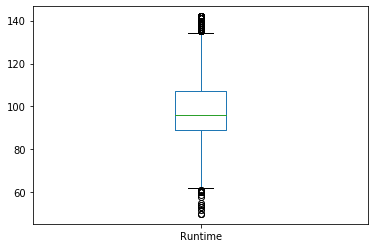

In [45]:
movies1.Runtime.plot.box()

c:\users\aange\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\users\aange\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.33951354026794434, 0.0)
(6712, 25)
(0.33951354026794434, 0.0)


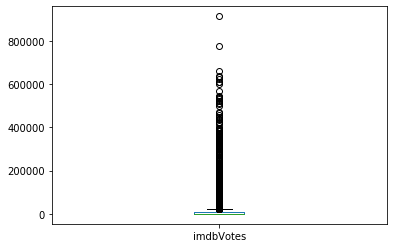

In [46]:
print(stats.shapiro(movies1.imdbVotes))

movies1.imdbVotes.plot.box()
mad = np.abs(movies1['imdbVotes'] - movies1['imdbVotes'].median()).median()*(1/0.6745)
# movies1 = movies1[(np.abs(movies1['imdbVotes']-movies1['imdbVotes'].median())/mad < 3.5)]
print(movies1.shape)
print(stats.shapiro(movies1.imdbVotes))


In [47]:
# movies1.imdbVotes.plot.box()

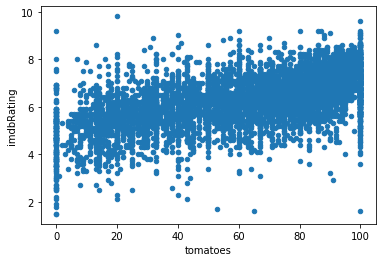

In [48]:
movies1.plot.scatter(x='tomatoes', y='imdbRating')

c:\users\aange\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9435673952102661, 7.006492321624085e-45)

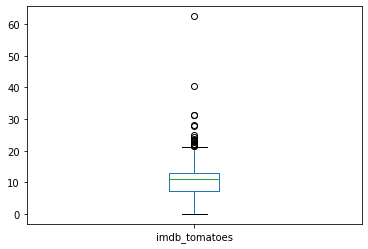

In [49]:
movies1['imdb_tomatoes'] = movies1.tomatoes / movies1.imdbRating
movies1.imdb_tomatoes.plot.box()
stats.shapiro(movies1.imdb_tomatoes)

6703


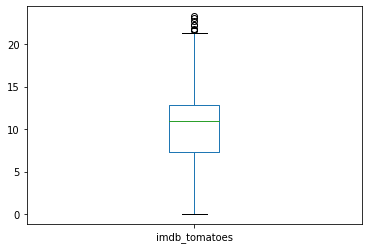

In [50]:
mad = abs(movies1['imdb_tomatoes'] - movies1['imdb_tomatoes'].median()).median()*(1/0.6745)
movies1 = movies1[abs(movies1['imdb_tomatoes']-movies1['imdb_tomatoes'].median())/mad < 3.5]
print(len(movies1))
movies1.imdb_tomatoes.plot.box()

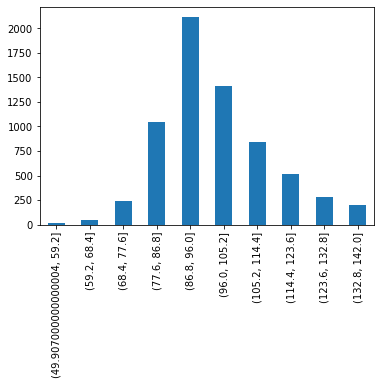

In [51]:
# e discretizacao de Runtime
movies1['runtime_dist'] = pd.cut(movies1.Runtime, 10, include_lowest=True)
movies1.runtime_dist.value_counts(sort=False).plot.bar()

In [57]:
columns = movies1.columns.tolist()
# columns = [c for c in columns if c not in ['Title', 'Released', 'Genre', 'Director', 'Writer', 'Language', 'Country', 'leading_actor']]
columns = [c for c in columns if c not in ['Title', 'runtime_dist']]

movies2 = movies1[columns]

# movies2.Released = pd.to_datetime(movies2['Released']).astype('int')
movies2.Genre = movies2.Genre.cat.codes
movies2.Director = movies2.Director.cat.codes
movies2.Writer = movies2.Writer.cat.codes
movies2.Language = movies2.Language.cat.codes
movies2.Country = movies2.Country.cat.codes
movies2.leading_actor = movies2.leading_actor.cat.codes
movies2.Rated = movies2.Rated.cat.codes
movies2.Production = movies2.Production.cat.codes

movies_norm = (movies2 - movies2.min()) / (movies2.max() - movies2.min())

# movies_norm = movies_norm.drop(columns=['golden_globes', 'baftas']) # colunas vazias
# movies1 = movies1.drop(columns=['golden_globes', 'baftas']) # colunas vazias
movies_norm.head()

,Year,Rated,Released,Runtime,Genre,Director,Writer,Language,Country,imdbRating,...,oscars,primetime_emmys,oscars_nom,baftas_nom,primetime_emmys_nom,golden_globes_nom,other_awards,other_nominations,leading_actor,imdb_tomatoes
imdbID,,,,,,,,,,,,,,,,,,,,,
tt1533818,0.1,0.600000,0.336315,0.695652,0.307692,0.277978,0.281348,0.280952,0.308458,0.626506,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.006135,0.806370,0.551940
tt1534075,0.1,0.555556,0.116790,0.423913,0.269231,0.516223,0.000000,0.242857,0.940299,0.686747,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.006135,0.547201,0.459861
tt1534085,0.1,0.733333,0.198569,0.652174,0.500000,0.717415,0.722968,0.242857,0.174129,0.542169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.021277,0.000000,0.655182,0.379833
tt1535101,0.2,0.733333,0.193202,0.695652,0.192308,0.689744,0.242493,0.242857,0.935323,0.590361,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.111750,0.376250
tt1535102,0.2,0.555556,0.250447,0.467391,0.192308,0.040934,0.041965,0.242857,0.940299,0.385542,...,0.0,0.0,0.0,0.0,0.0,0.0,0.017021,0.000000,0.854786,0.000000


In [58]:
# DESCARTADO; remove muitas instancias

from sklearn.ensemble import IsolationForest
rng = np.random.RandomState(42)
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(movies_norm)

scores = clf.predict(movies_norm)
movies_norm3 = movies_norm[scores != -1]
len(movies_norm3)

c:\users\aange\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
c:\users\aange\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
c:\users\aange\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


6032

In [59]:
from sklearn.covariance import EllipticEnvelope
detector = EllipticEnvelope(contamination=0.01)
detector.fit(movies_norm)
scores = detector.predict(movies_norm)

movies_norm1 = movies_norm[scores != -1]
len(movies_norm1)

6635

In [60]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=10, contamination=0.01)

movies_norm2 = movies_norm[lof.fit_predict(movies_norm) != -1]
len(movies_norm2)

6635

In [61]:
movies_norm = movies_norm1

movies1 = movies1[scores != -1]

# FINALIZAÇÃO DO PRE-PROCESSAMENTO

# Estatísticas descritivas & Testes de hipótese

In [62]:
movies_norm.corr(method='spearman')

,Year,Rated,Released,Runtime,Genre,Director,Writer,Language,Country,imdbRating,...,oscars,primetime_emmys,oscars_nom,baftas_nom,primetime_emmys_nom,golden_globes_nom,other_awards,other_nominations,leading_actor,imdb_tomatoes
Year,1.000000,0.013012,0.969266,0.123209,-0.080199,-0.002420,0.038993,-0.035865,0.012959,-0.058207,...,-0.001667,-0.006663,-0.021869,-0.010074,-0.015379,-0.026580,-0.253690,-0.249394,-0.014295,0.064967
Rated,0.013012,1.000000,0.005557,0.147793,-0.126502,-0.006264,0.054658,-0.163376,0.195586,-0.164123,...,0.038224,0.031303,0.067359,0.020081,0.014483,0.054781,0.036028,0.098971,-0.021406,-0.146642
Released,0.969266,0.005557,1.000000,0.106190,-0.057324,-0.006100,0.034499,-0.033927,-0.008952,-0.051544,...,-0.003069,-0.012844,-0.022909,-0.004276,-0.018755,-0.028938,-0.227000,-0.238249,-0.015820,0.093044
Runtime,0.123209,0.147793,0.106190,1.000000,-0.136631,0.034341,0.111469,0.193407,-0.158362,0.113180,...,0.063225,0.020070,0.084844,0.015911,0.005386,0.065201,0.117002,0.161319,0.025677,-0.143533
Genre,-0.080199,-0.126502,-0.057324,-0.136631,1.000000,-0.028213,-0.043700,-0.011434,-0.005780,0.026320,...,0.010436,0.006660,-0.053423,0.005529,0.000726,-0.051033,0.056507,0.017791,0.002156,0.146327
Director,-0.002420,-0.006264,-0.006100,0.034341,-0.028213,1.000000,0.441256,0.014596,-0.021176,-0.002234,...,-0.010072,-0.015904,0.014064,0.008406,0.011016,0.016816,-0.000667,-0.003468,0.035926,-0.014777
Writer,0.038993,0.054658,0.034499,0.111469,-0.043700,0.441256,1.000000,0.057883,-0.071752,-0.114529,...,-0.006472,-0.034158,0.005275,-0.011480,-0.006405,0.029099,0.026545,0.042458,0.054009,-0.086195
Language,-0.035865,-0.163376,-0.033927,0.193407,-0.011434,0.014596,0.057883,1.000000,-0.408979,0.117515,...,0.004102,-0.015756,-0.003171,-0.003444,-0.021587,-0.007156,0.160474,0.162401,0.035810,0.102118
Country,0.012959,0.195586,-0.008952,-0.158362,-0.005780,-0.021176,-0.071752,-0.408979,1.000000,-0.089671,...,0.011174,0.032338,0.015814,-0.004068,0.021906,0.018848,-0.143612,-0.147282,-0.036678,-0.087177
imdbRating,-0.058207,-0.164123,-0.051544,0.113180,0.026320,-0.002234,-0.114529,0.117515,-0.089671,1.000000,...,0.079904,0.048085,0.159099,0.059927,0.046880,0.056615,0.322840,0.270584,-0.001649,0.259100


In [63]:
movies_norm.corr(method='pearson')

,Year,Rated,Released,Runtime,Genre,Director,Writer,Language,Country,imdbRating,...,oscars,primetime_emmys,oscars_nom,baftas_nom,primetime_emmys_nom,golden_globes_nom,other_awards,other_nominations,leading_actor,imdb_tomatoes
Year,1.000000,-0.073127,0.967885,0.127024,-0.054811,-0.001766,0.038963,-0.035750,0.017286,-0.054738,...,0.000841,-0.005730,-0.009089,-0.002458,-0.017731,-0.023113,-0.134458,-0.092391,-0.014543,0.055572
Rated,-0.073127,1.000000,-0.080743,0.133127,-0.114427,-0.000757,0.042218,-0.126549,0.144576,-0.139299,...,0.036219,0.024296,0.070668,0.018702,0.002218,0.048356,0.086053,0.131212,-0.021852,-0.138079
Released,0.967885,-0.080743,1.000000,0.108200,-0.038336,-0.005221,0.035488,-0.026982,-0.002100,-0.048379,...,0.000298,-0.010222,-0.009358,0.004440,-0.018783,-0.025440,-0.122245,-0.090090,-0.016239,0.082846
Runtime,0.127024,0.133127,0.108200,1.000000,-0.175393,0.033592,0.105888,0.114041,-0.140993,0.104988,...,0.077085,0.018435,0.097106,0.007721,0.005235,0.068768,0.166743,0.225350,0.027766,-0.113558
Genre,-0.054811,-0.114427,-0.038336,-0.175393,1.000000,-0.028997,-0.038458,-0.003614,0.022358,-0.022702,...,-0.001869,0.006058,-0.046594,-0.003817,0.002986,-0.039008,-0.000854,-0.046479,0.000722,0.112195
Director,-0.001766,-0.000757,-0.005221,0.033592,-0.028997,1.000000,0.453075,-0.008922,-0.022025,-0.013536,...,-0.010305,-0.021395,0.014950,0.010728,0.007480,0.019546,-0.001476,0.006873,0.035581,-0.015625
Writer,0.038963,0.042218,0.035488,0.105888,-0.038458,0.453075,1.000000,0.020662,-0.062402,-0.106605,...,-0.008325,-0.029267,0.013663,-0.007691,-0.009415,0.031226,0.039946,0.050941,0.053446,-0.077696
Language,-0.035750,-0.126549,-0.026982,0.114041,-0.003614,-0.008922,0.020662,1.000000,-0.195923,0.088502,...,0.008814,-0.010961,-0.013364,0.002227,-0.014246,-0.011468,0.150259,0.086898,0.021650,0.103110
Country,0.017286,0.144576,-0.002100,-0.140993,0.022358,-0.022025,-0.062402,-0.195923,1.000000,-0.062579,...,0.016890,0.021655,0.030662,0.043703,0.020635,0.010749,-0.101741,-0.057795,-0.035563,-0.070624
imdbRating,-0.054738,-0.139299,-0.048379,0.104988,-0.022702,-0.013536,-0.106605,0.088502,-0.062579,1.000000,...,0.071327,0.045635,0.125373,0.051950,0.036615,0.046620,0.267944,0.244007,-0.003006,0.305126


In [64]:
movies1.dtypes

Title                        category
Year                            int64
Rated                        category
Released               datetime64[ns]
Runtime                       float64
Genre                        category
Director                     category
Writer                       category
Language                     category
Country                      category
imdbRating                    float64
imdbVotes                     float64
Production                   category
tomatoes                      float64
oscars                          int64
primetime_emmys                 int64
oscars_nom                      int64
baftas_nom                      int64
primetime_emmys_nom             int64
golden_globes_nom               int64
other_awards                    int64
other_nominations               int64
leading_actor                category
imdb_tomatoes                 float64
runtime_dist                 category
dtype: object

count    6635.000000
mean     2014.508063
std         2.312369
min      2009.000000
25%      2013.000000
50%      2014.000000
75%      2016.000000
max      2019.000000
Name: Year, dtype: float64
2014.0330110259692


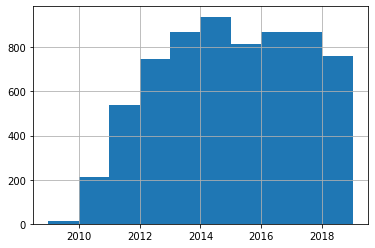

In [65]:
print(movies1.Year.describe())
movies1.Year.hist()
print(movies.Year.mean())

count    6635.000000
mean       98.331424
std        14.707018
min        50.000000
25%        89.000000
50%        96.000000
75%       107.000000
max       142.000000
Name: Runtime, dtype: float64
84.19296378508226


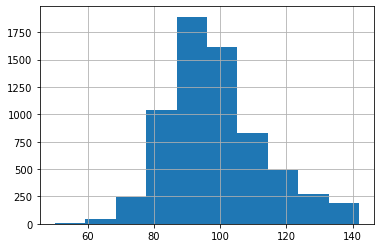

In [66]:
print(movies1.Runtime.describe())
movies1.Runtime.hist()
print(movies.Runtime.mean())

count    6635.000000
mean        6.315072
std         1.025865
min         1.500000
25%         5.700000
50%         6.400000
75%         7.100000
max         9.800000
Name: imdbRating, dtype: float64
6.284290065152858


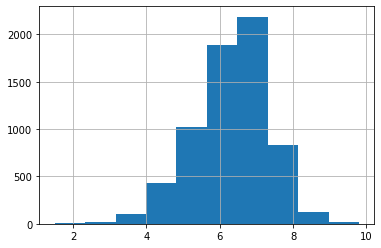

In [67]:
print(movies1.imdbRating.describe())
movies1.imdbRating.hist()
print(movies.imdbRating.mean())

count      6635.000000
mean      14977.454710
std       40657.424455
min           5.000000
25%         395.000000
50%        1792.000000
75%        8360.500000
max      398278.000000
Name: imdbVotes, dtype: float64


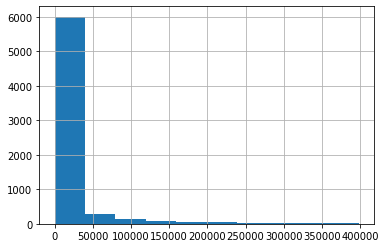

In [68]:
print(movies1.imdbVotes.describe())
movies1.imdbVotes.hist()
movies1['imdbVotes_log'] = movies1.imdbVotes.apply(np.log10)

count    6635.000000
mean        3.260719
std         0.969448
min         0.698970
25%         2.596597
50%         3.253338
75%         3.922232
max         5.600186
Name: imdbVotes_log, dtype: float64
1.970153844537521


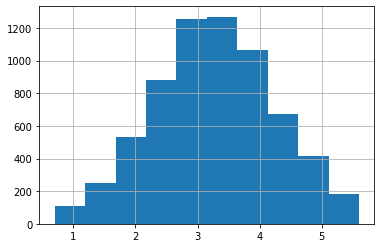

In [69]:
print(movies1.imdbVotes_log.describe())
movies1.imdbVotes_log.hist()
print(movies.imdbVotes.apply(np.log10).mean())

count    6635.000000
mean       63.916805
std        28.320164
min         0.000000
25%        43.000000
50%        70.000000
75%        88.000000
max       100.000000
Name: tomatoes, dtype: float64


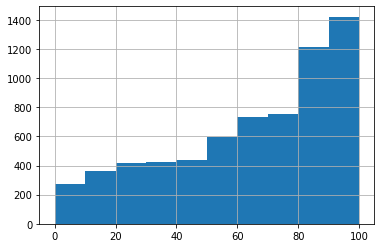

In [70]:
print(movies1.tomatoes.describe())
movies1.tomatoes.hist()

count     6635
unique     108
top        USA
freq      3247
Name: Country, dtype: object


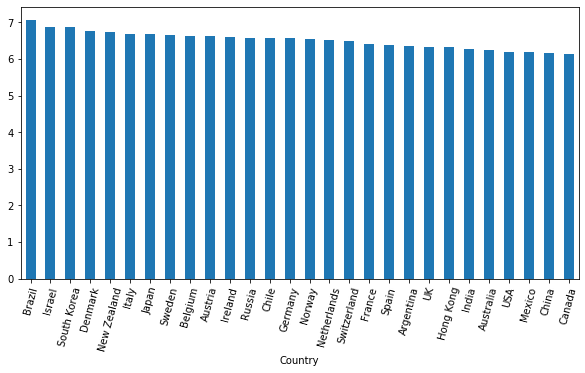

In [71]:
# Verificar se a nota do imdb é influenciada pelo país/continente do filme

print(movies1.Country.describe())
byCountry = movies1.groupby('Country').filter(lambda x : len(x) >= 20)
byCountry = byCountry.groupby(['Country'])
byCountry['imdbRating'].mean().nlargest(30).plot.bar(rot=75, figsize=(10, 5))

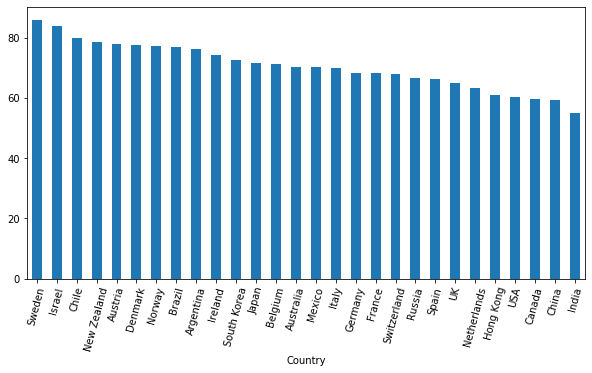

In [72]:
byCountry.tomatoes.mean().nlargest(30).plot.bar(rot=75, figsize=(10, 5)) # tomatoes

count     4851
unique      14
top          R
freq      1500
Name: Rated, dtype: object


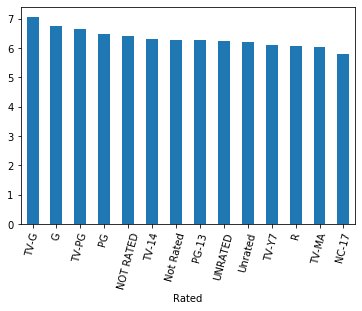

In [73]:
# Maiores notas do imdb por classificação indicativa

print(movies1.Rated.describe())
byRate = movies1.groupby('Rated')
byRate
byRate.imdbRating.mean().nlargest(25).plot.bar(rot=75)

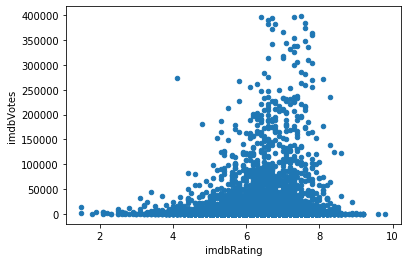

In [74]:
# movies1.plot.scatter(x='other_awards', y='tomatoes')
movies1['log_imdbVotes'] = movies1.imdbVotes.apply(np.log10)
movies1.plot.scatter(x='imdbRating', y='imdbVotes')

count            6635
unique           5131
top       Alex Gibney
freq               11
Name: Director, dtype: object


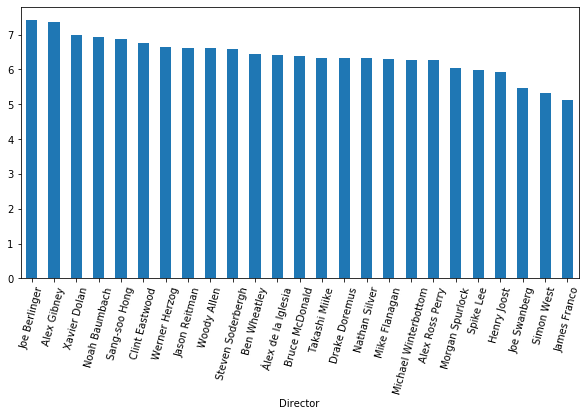

In [75]:
# 

print(movies1.Director.describe())
byDirector = movies1.groupby('Director').filter(lambda x : len(x) >= 5)
byDirector = byDirector.groupby('Director')
byDirector.imdbRating.mean().nlargest(25).plot.bar(rot=75, figsize=(10, 5))

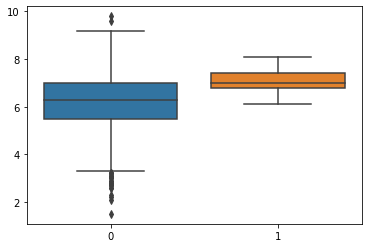

In [76]:
data1 = movies1[movies1.Country == 'USA'].imdbRating
data2 = movies1[movies1.Country == 'Brazil'].imdbRating

sns.boxplot(data=[data1, data2])

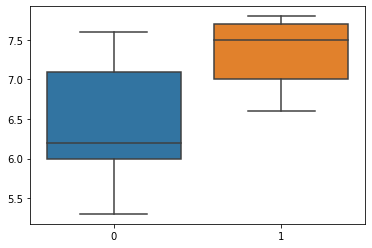

In [77]:
data1 = movies1[movies1.leading_actor == 'Brad Pitt'].imdbRating
data2 = movies1[movies1.leading_actor == 'Irrfan Khan'].imdbRating

sns.boxplot(data=[data1, data2])

count             6635
unique            4938
top       Nicolas Cage
freq                17
Name: leading_actor, dtype: object


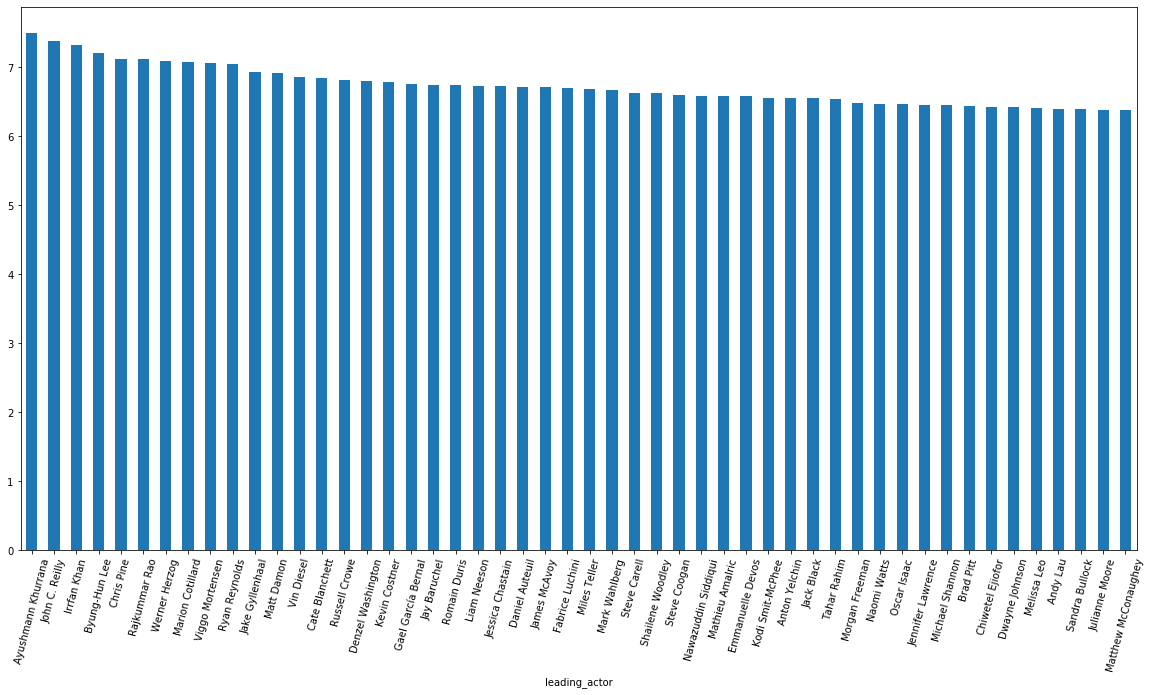

In [78]:
# 

print(movies1.leading_actor.describe())
by_leading_actor = movies1.groupby('leading_actor').filter(lambda x : len(x) >= 5)
by_leading_actor = by_leading_actor.groupby('leading_actor')
by_leading_actor.imdbRating.mean().nlargest(50).plot.bar(rot=75, figsize=(20, 10))

count      6635
unique       20
top       Drama
freq       1746
Name: Genre, dtype: object


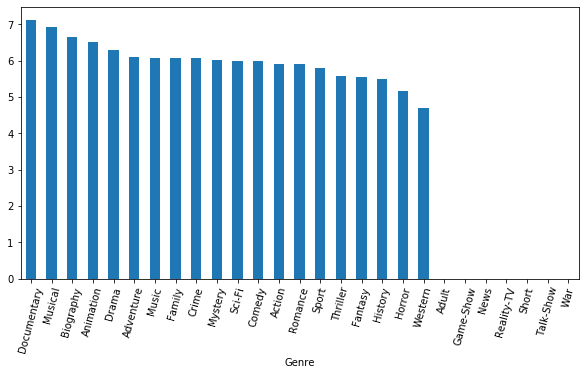

In [79]:
print(movies1.Genre.describe())
by_genre = movies1.groupby('Genre')
by_genre.imdbRating.mean().sort_values(ascending=False).plot.bar(rot=75, figsize=(10, 5))

In [80]:
len(movies1[movies1.oscars > 0])


23


# Parte 2


## Apesar de o imdbRating ser um atributo contínuo, foi optado por definir o problema em uma classificação binária para prever se um filme terá a nota `>= 7` ou  `< 7`, ou seja, se é um bom filme ou não

- Também foi testado anteriormente o modelo usando intervalos `{ (0, 2], (2, 4], (4, 6], (6, 8], (8, 10] }` como classes,  porém as métricas F1-score e accuracy estavam muito ruins, em torno de 50% para alguns classificadores, e com a mudança para decisão binária teve uma melhora na accurácia que subiu para mais de 70% em alguns casos

- Dessa forma também é possível ter uma margem de segurança em relação a regressão


### Encodando todos os valores categóricos para os classificadores e mais um pouco de pre-processamento

#### One-Hot-Encoding criaria muitas colunas, devido ao alto número de diferentes valores categóricos. Foi usado o LabelEncoder

In [81]:
from sklearn.preprocessing import LabelEncoder
import datetime as dt
from sklearn.model_selection import GridSearchCV

dataset = movies1.drop(columns=['Title', 'runtime_dist', 'imdbVotes_log', 'log_imdbVotes', 'imdb_tomatoes'])

# Os classificadores não leem datetime
dataset['Released'] = ((dataset['Released'] - dt.datetime(1970,1,1)).dt.total_seconds() / (60 * 60 * 24)).astype('int') #dias desde 1970-01-01

categorical_columns = list(dataset.select_dtypes(['category']).columns)

for col in categorical_columns:
  dataset[col] = dataset[col].str.upper().astype('category')
  if col in ['Rated', 'Writer', 'Production']:
    dataset[col] = dataset[col].cat.add_categories(['null'])
    dataset[col].fillna('null', inplace=True)

  dataset[col] = LabelEncoder().fit_transform(dataset[col])


dataset['target'] = dataset.imdbRating.apply(lambda x: x >= 7)
dataset.drop(columns=['imdbRating'], inplace=True)

print(dataset.shape)
dataset.target.value_counts()

(6635, 22)


False    4723
True     1912
Name: target, dtype: int64

## Setando os conjuntos de treinamento e teste com holdout set
### divisão de 75% - 25%

In [82]:
from sklearn.model_selection import train_test_split
target_names=['RUIM', 'BOM']

X_train, X_test, y_train, y_test = train_test_split(dataset.drop(columns=['target']), dataset['target'], test_size=.25, random_state=42)
print(y_train.shape, y_test.shape)
print(y_train.value_counts(), '\n', y_test.value_counts())

(4976,) (1659,)
False    3529
True     1447
Name: target, dtype: int64 
 False    1194
True      465
Name: target, dtype: int64


## sklearn imports

In [83]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## K-NN

### Aqui são variados os valores do hiperparâmetro K no intervalo [1, 30] e se o algoritmo vai usar peso ou não entre os vizinhos, sendo 'uniform' para pesos iguais para todos os vizinhos e 'distance' para peso inversamente proporcional a distância dos vizinhos

In [84]:
reports = []

c_matrices = dict()

for K in range(1, 30):
  for weights in ['uniform', 'distance']:
    knn = KNeighborsClassifier(n_neighbors=K, weights=weights, n_jobs=-1)

    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)
    
    c_matrices[str(K) + '_' + weights] = confusion_matrix(y_test, y_pred)

    clss_report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
#     Para informações por classes descomentar essas linhas
#     for target in target_names:
#       report[target + '_precision'] = clss_report[target]['precision']
#       report[target + '_recall'] = clss_report[target]['recall']
#       report[target + '_f1-score'] = clss_report[target]['f1-score']
#       report[target + '_support'] = clss_report[target]['support']
    report = clss_report['weighted avg']
    report['accuracy'] = clss_report['accuracy']
    report['k'] = K;
    report['weights'] = weights
    reports.append(report)
reports = pd.DataFrame(reports).drop(columns=['support'])

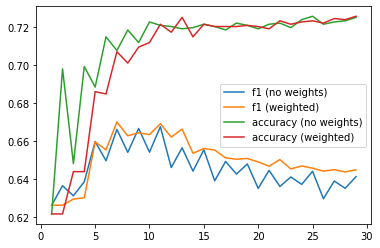

In [85]:
uniform=reports.weights == 'uniform'
distance=reports.weights == 'distance'
plt.plot(reports[uniform]['k'], reports[uniform]['f1-score'])
plt.plot(reports[distance]['k'], reports[distance]['f1-score'])
plt.plot(reports[uniform]['k'], reports[uniform]['accuracy'])
plt.plot(reports[distance]['k'], reports[distance]['accuracy'])
plt.legend(['f1 (no weights)', 'f1 (weighted)', 'accuracy (no weights)', 'accuracy (weighted)'], loc='center right')
plt.show()

#### Aqui pode ser observado que o para valores de K mais baixos se obtem um f1-score melhor mas não se tem uma precisão e recall muito bons e que o K-NN com pesos tem mais êxito

In [86]:
f1_score_knn = reports.sort_values(by=['f1-score'], ascending=False).iloc[:10, :]
f1_score_knn

,accuracy,f1-score,k,precision,recall,weights
13,0.707052,0.669951,7,0.664952,0.707052,distance
21,0.721519,0.669053,11,0.678254,0.721519,distance
20,0.720916,0.667470,11,0.676816,0.720916,uniform
16,0.711875,0.666530,9,0.665977,0.711875,uniform
25,0.725136,0.666234,13,0.683604,0.725136,distance
12,0.707655,0.666039,7,0.662360,0.707655,uniform
17,0.709464,0.664268,9,0.662429,0.709464,distance
19,0.711875,0.663305,10,0.663914,0.711875,distance
15,0.701025,0.662681,8,0.655851,0.701025,distance
23,0.717300,0.661974,12,0.669434,0.717300,distance


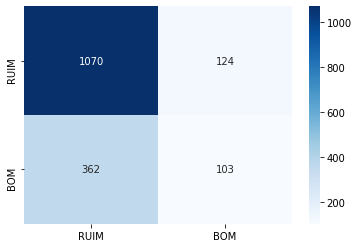

In [87]:
c_m = str(f1_score_knn['k'].iloc[0]) + '_' + f1_score_knn['weights'].iloc[0]
sns.heatmap(c_matrices[c_m], xticklabels=target_names, yticklabels=target_names, annot=True, cmap="Blues", fmt="d")

#### Mas a acurácia é melhor com valores de K mais altos e os pesos não influenciam tanto na acurácia

In [88]:
acc_knn = reports.sort_values(by=['accuracy'], ascending=False).iloc[:10, :]
acc_knn

,accuracy,f1-score,k,precision,recall,weights
57,0.725738,0.644759,29,0.687034,0.725738,distance
48,0.725738,0.643956,25,0.687379,0.725738,uniform
56,0.725136,0.641131,29,0.686013,0.725136,uniform
25,0.725136,0.666234,13,0.683604,0.725136,distance
53,0.724533,0.644791,27,0.682291,0.724533,distance
46,0.723930,0.637037,24,0.682161,0.723930,uniform
55,0.723930,0.643617,28,0.680286,0.723930,distance
49,0.723327,0.645587,25,0.677974,0.723327,distance
43,0.723327,0.650117,22,0.677951,0.723327,distance
54,0.723327,0.634958,28,0.680015,0.723327,uniform


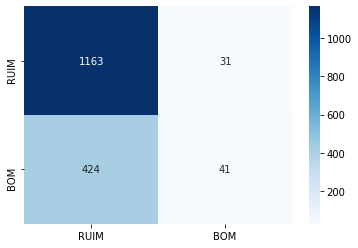

In [89]:
c_m = str(acc_knn['k'].iloc[0]) + '_' + acc_knn['weights'].iloc[0]
sns.heatmap(c_matrices[c_m], xticklabels=target_names, yticklabels=target_names, annot=True, cmap='Blues', fmt="d")

## Random Forest

### O número de árvores na random forest é calculado para o intervalo [50, 1000] com step de 50

In [90]:
n_trees = range(50, 1050, 50)

reports = []

c_matrices = dict()

for n_tree in n_trees:
  random_forest = RandomForestClassifier(n_estimators=n_tree, class_weight='balanced', random_state=42, n_jobs=-1)

  random_forest.fit(X_train, y_train)
  y_pred = random_forest.predict(X_test)
    
  c_matrices[n_tree] = confusion_matrix(y_test, y_pred)

  clss_report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
#   Para informações por classes descomentar essas linhas
#   for target in target_names:
#     report[target + '_precision'] = clss_report[target]['precision']
#     report[target + '_recall'] = clss_report[target]['recall']
#     report[target + '_f1-score'] = clss_report[target]['f1-score']
#     report[target + '_support'] = clss_report[target]['support']
  report = clss_report['weighted avg']
  report['accuracy'] = clss_report['accuracy']
  report['n_trees'] = n_tree
  reports.append(report)
reports = pd.DataFrame(reports).drop(columns=['support'])

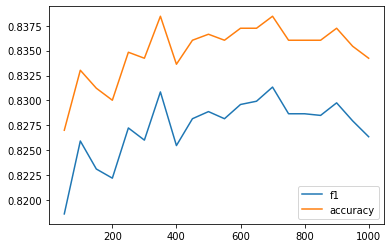

In [91]:
plt.plot(reports['n_trees'], reports['f1-score'])
plt.plot(reports['n_trees'], reports['accuracy'])
plt.legend(['f1', 'accuracy'], loc='lower right')
plt.show()

#### É possível ver que a ordem de acordo com o f1-score e acurácia permanece quase a mesma coisa com acurácia, precision, recall e f1-score ultrapassando os 81%

In [92]:
f1_score_rf = reports.sort_values(by=['f1-score'], ascending=False).iloc[:10, :]
f1_score_rf

,accuracy,f1-score,n_trees,precision,recall
13,0.838457,0.831340,700,0.833269,0.838457
6,0.838457,0.830853,350,0.833417,0.838457
12,0.837251,0.829919,650,0.831970,0.837251
17,0.837251,0.829755,900,0.832016,0.837251
11,0.837251,0.829591,600,0.832068,0.837251
9,0.836649,0.828876,500,0.831421,0.836649
15,0.836046,0.828659,800,0.830629,0.836046
14,0.836046,0.828659,750,0.830629,0.836046
16,0.836046,0.828494,850,0.830671,0.836046
10,0.836046,0.828161,550,0.830773,0.836046


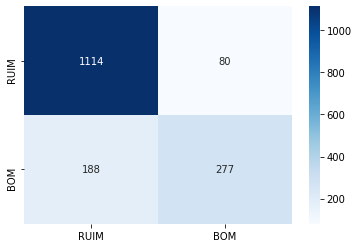

In [93]:
c_m = f1_score_rf['n_trees'].iloc[0]
sns.heatmap(c_matrices[c_m], xticklabels=target_names, yticklabels=target_names, annot=True, cmap='Blues', fmt="d")

In [94]:
acc_rf = reports.sort_values(by=['accuracy'], ascending=False).iloc[:10, :]
acc_rf

,accuracy,f1-score,n_trees,precision,recall
13,0.838457,0.831340,700,0.833269,0.838457
6,0.838457,0.830853,350,0.833417,0.838457
17,0.837251,0.829755,900,0.832016,0.837251
11,0.837251,0.829591,600,0.832068,0.837251
12,0.837251,0.829919,650,0.831970,0.837251
9,0.836649,0.828876,500,0.831421,0.836649
10,0.836046,0.828161,550,0.830773,0.836046
16,0.836046,0.828494,850,0.830671,0.836046
15,0.836046,0.828659,800,0.830629,0.836046
8,0.836046,0.828161,450,0.830773,0.836046


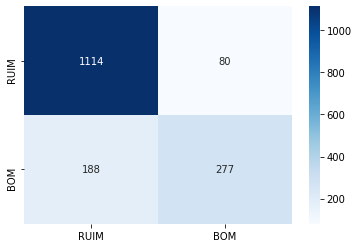

In [95]:
c_m = acc_rf['n_trees'].iloc[0]
sns.heatmap(c_matrices[c_m], xticklabels=target_names, yticklabels=target_names, annot=True, cmap='Blues', fmt="d")

## MLP

### Hiperparâmetros

In [96]:
hidden_layers = [(50,), (100,), (50, 50), (100, 100)]

solvers = ['sgd', 'adam']

activations = ['relu', 'logistic', 'tanh']

alphas = [.0001, .005]

learning_rates = ['constant', 'adaptive']

### Utilizando o Grid Search Cross Validation do Sci-kit learn para encontrar os melhores parâmetros para o MLP
Devido ao alto número de hiperparâmetros a visualização ficaria muito prejudicada.

In [97]:
mlp = MLPClassifier(random_state=42)

params = {
    'hidden_layer_sizes': hidden_layers,
    'activation': activations,
    'solver': solvers,
    'alpha': alphas,
    'learning_rate': learning_rates,
}

from sklearn.model_selection import GridSearchCV

mlp_grid_search = GridSearchCV(mlp, params, n_jobs=-1)

mlp_grid_search.fit(X_train, y_train)

c:\users\aange\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
c:\users\aange\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     rando...
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'activation': ['relu', 'logistic', 'tanh'],
                         'alpha': [0.0001, 0.005],
                         'hidde

#### Dessa forma é possível obter como melhores parâmetros a função de ativação rectified linear unit, alpha = 0.0001,  camada oculta de tamanho 100, etc.

In [98]:
mlp_grid_search.best_params_

{'activation': 'relu',
 'alpha': 0.0001,
 'hidden_layer_sizes': (50,),
 'learning_rate': 'constant',
 'solver': 'adam'}

### Teste:
#### Aqui é possível observar que embora o recall para classe RUIM tenha sido muito bom, foi péssimo para classe BOM, o que torna um bom classificador para filmes ruins, com uma  acurácia de 72%. Ou seja, se ele classifica um filme como RUIM, há uma grande probabilidade de ele realmente ser ruim (nota abaixo de 7)

              precision    recall  f1-score   support

        RUIM       0.75      0.97      0.85      1194
         BOM       0.70      0.17      0.27       465

    accuracy                           0.75      1659
   macro avg       0.72      0.57      0.56      1659
weighted avg       0.73      0.75      0.68      1659



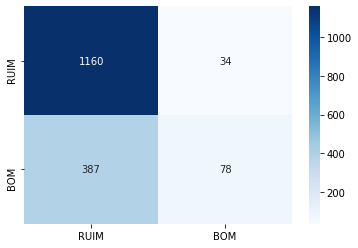

In [99]:
y_pred = mlp_grid_search.predict(X_test)

clf_report = classification_report(y_test, y_pred, target_names=target_names)
print(clf_report)
sns.heatmap(confusion_matrix(y_test, y_pred), xticklabels=target_names, yticklabels=target_names, annot=True, cmap='Blues', fmt="d")

## Complement Naive Bayes
[Definição](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html):
The Complement Naive Bayes classifier described in Rennie et al. (2003).
The Complement Naive Bayes classifier was designed to correct the “severe assumptions” made by the standard Multinomial Naive Bayes classifier. It is particularly suited for imbalanced data sets. The multinomial Naive Bayes classifier is suitable for classification with discrete features

Se encaixa no problema pelo fato de a classe BOM representar menos de 30% do dataset e ter muitos valores categóricos

### Hiperparâmetros

In [100]:
alphas = np.array([x/10 for x in range(0, 101)])
alphas

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. ])

In [101]:
reports = []

c_matrices = dict()

for alpha in alphas:
  bayes = ComplementNB(alpha=alpha, fit_prior=False, norm=True)

  bayes.fit(X_train, y_train)
  y_pred = bayes.predict(X_test)
    
  c_matrices[str(alpha)] = confusion_matrix(y_test, y_pred)

  clss_report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
#   Para informações por classes descomentar essas linhas
#   for target in target_names:
#     report[target + '_precision'] = clss_report[target]['precision']
#     report[target + '_recall'] = clss_report[target]['recall']
#     report[target + '_f1-score'] = clss_report[target]['f1-score']
#     report[target + '_support'] = clss_report[target]['support']
  report = clss_report['weighted avg']
  report['accuracy'] = clss_report['accuracy']
  report['alpha'] = alpha
  reports.append(report)
reports = pd.DataFrame(reports).drop(columns=['support'])

c:\users\aange\appdata\local\programs\python\python37\lib\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


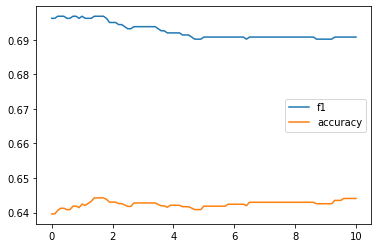

In [102]:
plt.plot(reports['alpha'], reports['accuracy'])
plt.plot(reports['alpha'], reports['f1-score'])
plt.legend(['f1', 'accuracy'], loc='center right')
plt.show()

In [103]:
f1_score_nb = reports.sort_values(by=['f1-score'], ascending=False).iloc[:10, :]
f1_score_nb

,accuracy,alpha,f1-score,precision,recall
14,0.696805,1.4,0.644235,0.636842,0.696805
17,0.696805,1.7,0.644235,0.636842,0.696805
16,0.696805,1.6,0.644235,0.636842,0.696805
15,0.696805,1.5,0.644235,0.636842,0.696805
100,0.690778,10.0,0.644062,0.633761,0.690778
99,0.690778,9.9,0.644062,0.633761,0.690778
98,0.690778,9.8,0.644062,0.633761,0.690778
97,0.690778,9.7,0.644062,0.633761,0.690778
96,0.690778,9.6,0.644062,0.633761,0.690778
18,0.696203,1.8,0.643822,0.636086,0.696203


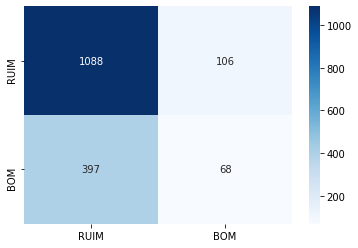

In [104]:
c_m = f1_score_nb['alpha'].iloc[0]
sns.heatmap(c_matrices[str(c_m)], xticklabels=target_names, yticklabels=target_names, annot=True, cmap='Blues', fmt="d")

## Conclusão

- De todos os algoritmos avaliados o Random Forest foi o que obteve melhor resultado conseguindo uma acurácia de mais de 82% e F1-score de mais de 81%
- O Complemente Naive Bayes apesar de prometer uma adequação ao problema não foi capaz de entregar bons resultados, talvez pelo fato de não estabelecer correlação entre as features
- O KNN e MLP atingiram resultados medianos mas com um bom Recall e Precision para a classe RUIM, sendo bons classificadores de filmes que ficarão com nota abaixo de 7 no IMDb